In [1]:
#cell 1 - load obt 
import os
from dotenv import load_dotenv
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl

# 加载本地.env文件
load_dotenv()

# 从环境变量读取连接信息
USER = os.getenv("DB_USER")
PASSWORD = os.getenv("DB_PASS")
HOST = os.getenv("DB_HOST","localhost")
PORT = os.getenv("DB_PORT","5432")
DB = os.getenv("DB_NAME")

# 检查读取是否成功(调试用)
if not PASSWORD:
    print("警告:未找到数据库密码,请检查.env文件")
else:
    print("配置加载成功(具体信息已隐藏)")

engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")
df_rfm = pd.read_sql("SELECT * FROM analysis.analysis_user_rfm", engine)

# 基础检查
df_rfm.shape, df_rfm.describe()

配置加载成功(具体信息已隐藏)


((93350, 18),
           frequency      monetary  avg_delay_days  severe_late_rate  \
 count  93350.000000  93350.000000    93350.000000      93350.000000   
 mean       1.033423    165.196388      -10.929788          0.053807   
 std        0.209106    226.322448        9.976076          0.224330   
 min        1.000000      0.000000     -146.000000          0.000000   
 25%        1.000000     63.050000      -16.000000          0.000000   
 50%        1.000000    107.780000      -11.000000          0.000000   
 75%        1.000000    182.547500       -6.000000          0.000000   
 max       15.000000  13664.080000      188.000000          1.000000   
 
        monetary_90d  monetary_365d  monetary_long  recency_days       r_score  \
 count  93350.000000   93350.000000   93350.000000  93350.000000  93350.000000   
 mean     163.531332     165.032519     165.196388    238.487156      2.451730   
 std      224.726393     226.169392     226.322448    152.593536      1.170918   
 min    

总复购率: 3.00%


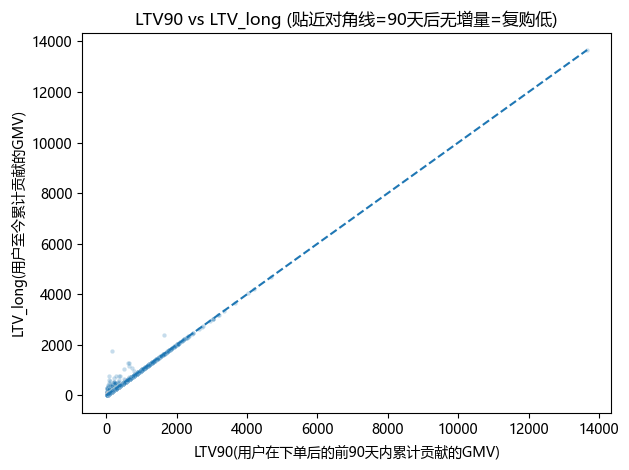

In [3]:
#cell 2 - analysis
# ===========================
# 1.复购率初步分析
# ===========================
# 标记复购用户
df_rfm["is_repurchase"] = (df_rfm["frequency"] > 1).astype("int8")

# 计算核心指标(复购率)
repurchase_rate = df_rfm["is_repurchase"].mean()
churn_rate = 1 - repurchase_rate

print(f"总复购率: {repurchase_rate:.2%}")

# ============================
# 2.LTV数据展示
# ============================
# 避免中文无法正常显示
mpl.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Noto Sans CJK SC", "Source Han Sans SC"]

col_90,col_long = "monetary_90d","monetary_long"
p = df_rfm[[col_90,col_long]].dropna().sample(min(20000,len(df_rfm)),random_state=42)

sns.scatterplot(data=p,x=col_90,y=col_long,s=10,alpha=0.25)

m = p[[col_90, col_long]].to_numpy().max()
plt.plot([0, m], [0, m], "--")  # y=x 参考线
plt.title("LTV90 vs LTV_long (贴近对角线=90天后无增量=复购低)")
plt.xlabel("LTV90(用户在下单后的前90天内累计贡献的GMV)")
plt.ylabel("LTV_long(用户至今累计贡献的GMV)")
plt.tight_layout()
plt.show()

